In [35]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### Tetris Bot

In [1]:
import gym_tetris
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
cuda:0


In [2]:
env = gym_tetris.make('Tetris-v0')
BATCH_SIZE = 196
GAMMA = 0.9
MULISTEP_GAMMA = 0.98
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 5000000
TARGET_UPDATE = 50
NUM_STATES = env.action_space.n
MULTISTEP_PARAM = 5
MOVEMENT_COST = 0.01

steps_done = 0

def curr_eps(steps):
    return EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps / EPS_DECAY)

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.bias = []
        self.bias_sum = 0
        self.position = 0

    def push(self, *args, bias=1):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            self.bias.append(None)
            self.bias_sum += bias
        else:
            # Don't add if small bias
            if bias < self.bias_sum / len(self.memory) * (curr_eps(steps_done) - EPS_END):
                return
            self.bias_sum -= self.bias[self.position]
            self.bias_sum += bias
        self.memory[self.position] = Transition(*args)
        self.bias[self.position] = bias
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, biased=True):
        if biased:
            choice_indices = np.random.choice(len(self.memory), size=batch_size, replace=False, p=np.array(self.bias) / self.bias_sum)
            return [self.memory[i] for i in choice_indices]
        else:
            return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
# I figure, if we've abstracted away the problem, we can get rid of the convolutional 
#  layers and make it fully dense...
# Will add those in later when we can get the toy model to work, I guess
class DQN(nn.Module):
    def __init__(self, h, w):
        super(DQN, self).__init__()
        self.input_layer_width = h * w
        self.fc1 = nn.Linear(self.input_layer_width, self.input_layer_width * 3)
        self.fc2 = nn.Linear(self.input_layer_width * 3, self.input_layer_width * 8)
        self.fc3 = nn.Linear(self.input_layer_width * 8, self.input_layer_width * 3)
        self.fc4 = nn.Linear(self.input_layer_width * 3, self.input_layer_width)
        self.output_layer = nn.Linear(self.input_layer_width, 12)

    # Called with either one element to determine next action, or a batch
    def forward(self, x):
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.output_layer(x)

In [5]:
def clean_state(state_var):
    """Returns a greyscale image with pixels taking values in [0,1]. Also adds a batch dimension"""
    greyscale  = np.sum(state_var, axis=2) / (3 * 255)
    return greyscale

def compress_board(state):
    """Assumes board greyscale"""
    small_board = state[10:423:20, 20:213:20]
    next_piece = state[180:241:20, 235:296:20]
    return small_board, next_piece

def combine_board_and_piece(board, piece):
    return board

def get_screen(screen=None, human=False):
    if screen is None and not human:
        screen = env.render(mode='rgb_array')
    if human:
        bla = env.render()
        screen = env.env.screen
        
    # Turn greyscale
    screen = clean_state(screen)
    
    # Compress
    screen, piece = compress_board(screen)
    screen = combine_board_and_piece(screen, piece)
    
    # Resize and add a batch dimension (BCHW)
    tensor = torch.from_numpy(screen).unsqueeze(0).unsqueeze(0)
    # Push to floats on GPU
    return tensor.type(torch.FloatTensor).to(device)

In [6]:
# Get screen size so that we can initialize layers correctly based on shape
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

In [7]:
load_net_prefix = './models/tetrisBot6v'
load_net_number = 0
net_to_load = f'{load_net_prefix}{load_net_number}'
try:
    policy_net = torch.load(net_to_load)
    policy_net.eval()
    target_net = torch.load(net_to_load)
    target_net.eval()
    print(f'{net_to_load} loaded...')
except:
    policy_net = DQN(screen_height, screen_width).to(device)
    target_net = DQN(screen_height, screen_width).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    print(f'Fell back to creating a new net...')

./models/tetrisBot6v0 loaded...


In [8]:
optimizer = optim.Adam(policy_net.parameters(), lr=10**-4)
memory = ReplayMemory(1000000)

def select_action(state, deterministic=False):
    global steps_done
    sample = random.random()
    eps_threshold = curr_eps(steps_done)
    steps_done += 1
    if sample > eps_threshold and not deterministic:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(NUM_STATES)]], device=device, dtype=torch.long)


episode_durations = []
lines_cleared = []

def plot_durations(save=None):
    fig = plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    plt.plot(np.array(lines_cleared) * 200)
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    
    if save is not None:
        fig.savefig(save, bbox_inches='tight')
        
    if is_ipython:
        display.clear_output(wait=True)
#         display.display(plt.gcf())
        plt.show()

In [9]:
def compute_loss_single(state, action, next_state, reward):
    return _compute_loss(state, action, next_state, reward, batch_size=1)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE, biased=False)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    next_state_batch = torch.cat(batch.next_state)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Huber loss
    loss = _compute_loss(state_batch, action_batch, next_state_batch, reward_batch)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def _compute_loss(_state, _action, _next_state, _reward, batch_size=BATCH_SIZE):
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(_state).gather(1, _action)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
#     next_state_values = target_net(_next_state).max(1)[0].detach()
    
#     Double Q learning:
    next_state_values = target_net(get_screen())[0][policy_net(get_screen()).argmax(1)[0]].detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + _reward

    # Compute Huber loss
    return F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

In [10]:
def did_piece_fall(env):
    return (env.unwrapped.game.falling_piece is None)

def create_reward(this_env, block_placed, action, is_done, info,
                  old_height, old_lines, hole_count=0, hole_towers=0,
                  include_height=True, include_score=True, include_holes=True, include_towers=True):
    """Assumes states are 21 x 10"""
    if not block_placed:
        # Punish a little for doing something that isn't the empty move
        if action == 0:
            return 0
        else:
            return -MOVEMENT_COST
    if is_done:
        return -50.0
    
    total_reward = 0
    if include_height:
        if info['height'] > old_height: 
            # Punish a little more the closer you are to the top
            total_reward += (1 + info['height'] / 10) * (old_height - info['height']) /3
    
    line_diff = this_env.unwrapped.game.complete_lines - old_lines
    if include_score and line_diff != 0:
        total_reward += 20 * 2 ** (line_diff)
    
    if include_holes:
        total_reward -= hole_count * 1.5
    if include_towers:
        total_reward -= include_towers
    
    return total_reward

def num_holes(state):
    flat_state = np.where(state.cpu() > 0, 1, 0).squeeze(0).squeeze(0)
    return np.sum(np.where((np.roll(flat_state, flat_state.shape[1]) > 0) & (flat_state == 0), 1, 0)[1:, :])

def num_holy_towers(state):
    """This is a fucking work of art"""
    flat_state = np.where(state.cpu() > 0, 1, 0).squeeze(0).squeeze(0)
    mask = np.where((np.roll(flat_state, flat_state.shape[1]) > 0) & (flat_state == 0), 1, 0)
    return np.sum(np.where(mask, flat_state.cumsum(axis=0), 0))

def train(num_episodes = 1000, human=False): 
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        height, lines = 0, 0
        env.reset()
        last_state = get_screen(human=human)
        state = get_screen(human=human)
        hole_count = 0 
        hole_reward = 0
        tower_count = 0 
        tower_reward = 0
        if not human:
            state_array = [last_state] * MULTISTEP_PARAM
            reward_array = [0] * MULTISTEP_PARAM
            
            reward_sum = 0
            array_pos = 0
            next_array_pos = 1
            warmup = 1
        for t in count():

            # Select and perform an action
            action = select_action(state, deterministic=human)
            # Can only perform an action once every three frames anyway...
            state, _, done, info = env.step(action.item())
            piece_fell = did_piece_fall(env)
            if not done:
                state, _, done, info = env.step(0)
                piece_fell = (piece_fell or did_piece_fall(env))
            if not done:
                state, _, done, info = env.step(0)
                piece_fell = (piece_fell or did_piece_fall(env))

            # Observe new state
            state = get_screen(state, human)
            
            if not human:
                state_array[array_pos] = state
                
                # Rewards
                if piece_fell:
                    # Holes
                    new_holes = num_holes(last_state)
                    holes_reward = new_holes - hole_count
                    hole_count = new_holes
                    # Towers
                    new_towers = num_holy_towers(last_state)
                    tower_reward = new_towers - tower_count
                    tower_count = new_towers
                else:
                    holes_reward = 0
                    tower_reward = 0
                    
                reward_single = create_reward(env, piece_fell, action, done, info, height, lines, holes_reward, tower_reward)
                reward_sum = (MULISTEP_GAMMA * reward_sum) + reward_single - (MULISTEP_GAMMA ** MULTISTEP_PARAM) * reward_array[array_pos]
                reward_array[array_pos] = reward_single
                reward_sum = torch.tensor([reward_sum], device=device).type(torch.float)
                
                # Store the transition in memory
                if warmup > MULTISTEP_PARAM:
                    with torch.no_grad():
                        loss = compute_loss_single(state_array[next_array_pos], action, state, reward_sum) ** ((1 - curr_eps(steps_done)) / 2 + 0.05)
                    memory.push(state_array[next_array_pos], action, state, reward_sum, bias=np.array([loss.cpu()])[0])
                
                # Perform one step of the optimization (on the target network)
                optimize_model()
                if done:
                    episode_durations.append(t + 1)
                    lines_cleared.append(lines)
                    plot_durations('latest.png')
                    break

            else:
                if done:
                    break

            # Set up params for next cycle
            height = info['height']
            lines = env.unwrapped.game.complete_lines
            last_state = state
            if not human:
                array_pos = (array_pos + 1) % MULTISTEP_PARAM
                next_array_pos = (next_array_pos + 1) % MULTISTEP_PARAM
                warmup += 1
            
        if not human:
            # Update the target network, copying all weights and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

def watch_model(rounds=1000):
    with torch.no_grad():
        train(rounds, human=True)

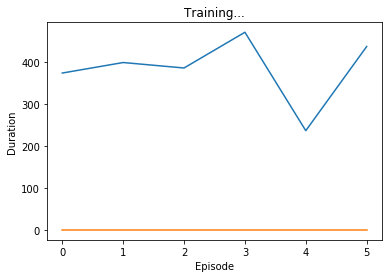

In [15]:
# Testing
train(5)

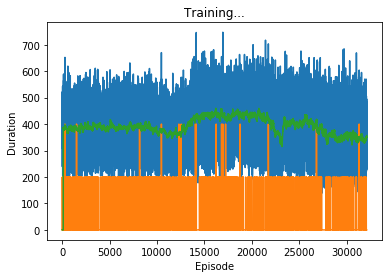

In [ ]:
idx = 1
while True:
    train(2000)
    torch.save(policy_net, f'{load_net_prefix}{idx}')
    idx += 1

In [13]:
watch_model()

KeyboardInterrupt: 